In [1]:
from surgeon_recording.reader import Reader
from glob import glob
from os.path import join
import os
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd

import cv2
import csv
from natsort import natsorted
from surgeon_recording.synchronization import Synchro

from moviepy.editor import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import moviepy.video.io.ImageSequenceClip

In [2]:
synchro = Synchro()

# Manual entries

In [19]:
#recording_session = 'SFITS_28_03_22'
#subject = 'MAXIME'
#fps_gopro = 59.940
#fps_rs = 30
#fps_micro = 30
#sensors = []

recording_session = 'test_19_04_22'
subject = 'ANAELLE_all4'
fps_gopro = 30   #test at LASA: gopro = oneplus, 30fps ATTENTION pour conversion besoin de set la resolution (mais de toute facon on utilisera pas ET fait pas des segments donc ok)
fps_rs = 30
fps_micro = 60       #test at LASA: microscope + gopro, 59.940
sensors = ['optitrack', 'emg', 'tps']


path_to_data_folder = '/home/anaelle/git/surgeon_recording/data'                 #lasa computer
#path_to_data_folder = '/Users/anael/Documents/GitHub/surgeon_recordings/data'   #windows computer



#synchro mouvement frames --> REPLACE BY READ FROM CSV FILE
#rs_frame = 694
#micro_frame = 384
#gopro_frame = 1217

#rs_abs_time = 1648459085159.2    #REMPLACER AVEC LES INFOS DES PNG
#rs_nb_frame = 66934


In [20]:
# read synchro frames from csv
data_folder = join('..', 'data', recording_session , subject)

file = 'synchro_frame.csv'
directory = join(data_folder, file)

data = pd.read_csv(directory)
rs_frame = int(data['rs_frame'])
micro_frame = int(data['micro_frame'])
gopro_frame = int(data['gopro_frame'])

frame = {
    "REALSENSE": rs_frame,
    "GOPRO": gopro_frame,
    "MICROSCOPE": micro_frame
}
frame

fps = {
    "GOPRO": fps_gopro,
    "MICROSCOPE": fps_micro,
    "REALSENSE": fps_rs
}

cameras = ['GOPRO', 'MICROSCOPE', 'REALSENSE']
folder = ['complete','segments']



In [5]:
print('WARNING: need to create the appropriate folders: GOPRO, MICROSCOPE, REALSENSE, CSV, PNG, complete, segments')

# Convert video

## get segments into one video (gopro, microscope)


In [7]:
# convert microscope and gopro mp4 video
for camera in cameras:
    L =[]
    if camera != 'REALSENSE':
        
        for root, dirs, files in os.walk(join(data_folder, camera, 'segments')):
            files = natsorted(files)
            print(files)
            for file in files:
                if os.path.splitext(file)[1] == '.mp4' or os.path.splitext(file)[1] == '.MP4':
                    filePath = os.path.join(root, file)
                    video = VideoFileClip(filePath)
                    #video = VideoFileClip(filePath, target_resolution=(1920, 1080))              # need to set manually resolution for oneplus videos
                    L.append(video)
        tmp = 'output' + camera + '.mp4'
        output_path = join(data_folder, camera, 'complete', tmp)
        final_clip = concatenate_videoclips(L)
        final_clip.write_videofile(output_path, fps=fps[camera], remove_temp=True, audio = False)
        

['VID_20220419_165912.mp4']
Moviepy - Building video ../data/test_19_04_22/ANAELLE_all4/GOPRO/complete/outputGOPRO.mp4.
Moviepy - Writing video ../data/test_19_04_22/ANAELLE_all4/GOPRO/complete/outputGOPRO.mp4



Moviepy - Done !
Moviepy - video ready ../data/test_19_04_22/ANAELLE_all4/GOPRO/complete/outputGOPRO.mp4


## bag to png to mp4

In [8]:
# extract the png with the converter (from shell) to the folder PNG in the folder REALSENSE in the SUBJECT folder
data_folder = join('..', 'data', recording_session , subject)
camera = 'REALSENSE'

bag_file = [x[2] for x in os.walk(join(data_folder, camera, 'BAG'))]
print(bag_file[0][0])

path_bag_file = join(path_to_data_folder, recording_session , subject, camera, 'BAG', bag_file[0][0])
print(path_bag_file)
path_png=  join(path_to_data_folder, recording_session , subject,  camera, 'PNG', 'a')
print(path_png)
os.system('rs-convert -i ' + path_bag_file + ' -p ' + path_png)

20220419_165835.bag
/home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/REALSENSE/BAG/20220419_165835.bag
/home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/REALSENSE/PNG/a
100%
PNG converter
	10227 Color frame(s) processed



0

In [9]:
image_folder=join(data_folder, camera, 'PNG')
image_files = [os.path.join(image_folder,img) for img in os.listdir(image_folder) if img.endswith(".png")]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(natsorted(image_files), fps=fps[camera])
path_mp4 = join(data_folder, camera, 'complete', 'rs_converted.mp4')
print('mp4 file: ' + path_mp4)
clip.write_videofile(path_mp4)

mp4 file: ../data/test_19_04_22/ANAELLE_all4/REALSENSE/complete/rs_converted.mp4
Moviepy - Building video ../data/test_19_04_22/ANAELLE_all4/REALSENSE/complete/rs_converted.mp4.
Moviepy - Writing video ../data/test_19_04_22/ANAELLE_all4/REALSENSE/complete/rs_converted.mp4



Moviepy - Done !
Moviepy - video ready ../data/test_19_04_22/ANAELLE_all4/REALSENSE/complete/rs_converted.mp4


# Get absolute time from png names

In [21]:
# file directory to access the png files (Attention: also in the function to get video from png)
camera = 'REALSENSE'
image_folder=join(data_folder, camera, 'PNG')
image_files = [os.path.join(image_folder,img) for img in os.listdir(image_folder) if img.endswith(".png")]

# get nb of frames of the rs camera
rs_nb_frame = len(image_files)

# get absolute time vector of rs from png files
abs_time_vector = {}
abs_time_vector[camera] = [name[-32:-4] for name in natsorted(image_files)]

rs_abs_time = float(abs_time_vector['REALSENSE'][rs_frame]) #abs time vector from png names

# Writ CSV files

## Get nb of frames

In [22]:
# get the nub of frames for each segments and the total videos for the gopro and microscope

nb_frames = {}
sum_frame = {}


for k in range(len(cameras)):    #for the different cameras
    camera = cameras[k]
    sum_frame[camera] = {}
    for j in range(len(folder)):  #segments and complete
        files = [x[2] for x in os.walk(join(data_folder, camera,folder[j]))]   #get the nam of the files of the video
        tmp = 0
        if camera == 'REALSENSE':
                    nb_frames[camera] = rs_nb_frame
        else:
            if len(files) != 0:                                                    # exclude rs for now bc no files
                for i in range(len(files[0])):                                   
                    file = files[0][i]                                             # prend la valeur des differents fichiers a la suite (les videos)
                
                    if os.path.splitext(file)[1] == '.MP4' or os.path.splitext(file)[1] == '.mp4':   #check si bien une video
                    #print(join(data_folder, folder[j], file))
                        cap = cv2.VideoCapture(join(data_folder, camera, folder[j], file))
                        nb_frames[file] = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                     # store nb of frames with file name as key
                
                        if folder[j] == 'segments':                                # si on est dans le fichiers des segments on calcule la somme de tous les segments
                            tmp = tmp + nb_frames[file]
                            sum_frame[camera] = tmp
                
                #print(file, '  nb of frames:   ', nb_frames[file] )
    print('Total nb of frames of segments for ', camera, sum_frame[camera])   
print('Nb of frames of the output GOPRO video:   ' , nb_frames['outputGOPRO.mp4'])
print('Nb of frames of the output MICROSCOPE video:   ', nb_frames['outputMICROSCOPE.mp4'])
print('Nb of frames of the output RS video:   ', nb_frames['REALSENSE'])  
#print(nb_frames) #ok le nb of frame obtenu pour les segments coresp. a celui donne par Resolve
  

Total nb of frames of segments for  GOPRO 9924
Total nb of frames of segments for  MICROSCOPE 21945
Total nb of frames of segments for  REALSENSE {}
Nb of frames of the output GOPRO video:    9896
Nb of frames of the output MICROSCOPE video:    21946
Nb of frames of the output RS video:    10227


## write CSV with absolute time for RS coming from PNG, and absolute time starting on the frame of the mvmt for the other, based on the abs time of RS

### method 1 

In [23]:
csv_names = []

for k in range(len(cameras)):
    camera = cameras[k]
    
    for j in range(len(folder)):
        files = [x[2] for x in os.walk(join(data_folder, camera ,folder[j]))]
        print(files)  
        
        if camera == 'REALSENSE':
            
            rs_csv = join(data_folder,camera, 'CSV', 'complete', 'REALSENSE_abs_time.csv')
            f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    
            # create the csv writer
            writer = csv.writer(f)
            header = ['index','frequency','relative_time','abs_time']
            # write a row to the csv file
            writer.writerow(header)
            rel_time = 0
            #abs_time = rs_abs_time                                        #put the ref_abs time we got from RS as the first absolute time to write
            
            for m in range((nb_frames[camera])):                            #pour toutes les frames
                abs_time = abs_time_vector['REALSENSE'][m]
                        #if m >= frame[camera]:        # si on est dans les videos completes et que l-indice est plus grand que la frame avec le mvmt de ref
                row = [m,fps[camera],rel_time,float(abs_time)]               # alors on inscrit le abs time, et a partir de la on l'incremente de la fps (en ms)
                            #abs_time = abs_time + 1/fps[camera]*1000
                        #else:
                            #row = [m, fps[camera], rel_time]                      # sinon on est soit dans les segments (pas besoin absolute time), soit on est avant le mvmt de ref donc pas de abs time
                    
                writer.writerow(row)
                rel_time = rel_time + 1/fps[camera]                       # on incremente le rel time par la fps corespondante 
                            
            print(float(abs_time)-1/fps[camera]*1000)
            f.close()        
            
        else:
            for i in range(len(files[0])):
                file = files[0][i] 
                if os.path.splitext(file)[1] == '.mp4' or os.path.splitext(file)[1] == '.MP4':
            
                    csv_names.append(join(data_folder,camera, 'CSV',folder[j], str(file)[0:10] + '_abs_time.csv'))  #create the csv references
                    f = open(csv_names[-1], 'w') # open the file in the write mode                        #open last one
    
    
                    # create the csv writer
                    writer = csv.writer(f)
                    header = ['index','frequency','relative_time','abs_time']
    
                    # write a row to the csv file
                    writer.writerow(header)
                    rel_time = 0
                    abs_time = rs_abs_time                                        #put the ref_abs time we got from RS as the first absolute time to write
                    #print(file)
                    
                    for m in range((nb_frames[file])):                            #pour toutes les frames
                        if folder[j] == 'complete' and m >= frame[camera]:        # si on est dans les videos completes et que l-indice est plus grand que la frame avec le mvmt de ref
                            row = [m,fps[camera],rel_time,abs_time]               # alors on inscrit le abs time, et a partir de la on l'incremente de la fps (en ms)
                            abs_time = abs_time + 1/fps[camera]*1000
                        else:
                            row = [m, fps[camera], rel_time]                      # sinon on est soit dans les segments (pas besoin absolute time), soit on est avant le mvmt de ref donc pas de abs time
                    
                        writer.writerow(row)
                        rel_time = rel_time + 1/fps[camera]                       # on incremente le rel time par la fps corespondante 
                            
           
                    f.close()

[['outputGOPRO.mp4']]
[['VID_20220419_165912.mp4']]
[['outputMICROSCOPE.mp4']]
[['GH013718.MP4']]
[['rs_converted.mp4']]
1650380671455.4204
[]
1650380671455.4204


### method 2 test to get relaive time of RS from absolute time 

In [18]:
csv_names = []


for k in range(len(cameras)):
    camera = cameras[k]
    
    for j in range(len(folder)):
        files = [x[2] for x in os.walk(join(data_folder, camera ,folder[j]))]
        print(files)  
        
        if camera == 'REALSENSE':
            
            rs_csv = join(data_folder,camera, 'CSV', 'complete', 'REALSENSE_abs_time2.csv')
            f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    
            # create the csv writer
            writer = csv.writer(f)
            header = ['index','frequency','relative_time','abs_time', 'freq']
            # write a row to the csv file
            writer.writerow(header)
            rel_time = 0
            #abs_time = rs_abs_time                                        #put the ref_abs time we got from RS as the first absolute time to write
            delta_t = 1
            
            for m in range((nb_frames[camera])):                            #pour toutes les frames
                abs_time = abs_time_vector['REALSENSE'][m]
                        #if m >= frame[camera]:        # si on est dans les videos completes et que l-indice est plus grand que la frame avec le mvmt de ref
                row = [m,fps[camera],rel_time,float(abs_time), 1/delta_t]               # alors on inscrit le abs time, et a partir de la on l'incremente de la fps (en ms)
                            #abs_time = abs_time + 1/fps[camera]*1000
                        #else:
                            #row = [m, fps[camera], rel_time]                      # sinon on est soit dans les segments (pas besoin absolute time), soit on est avant le mvmt de ref donc pas de abs time
                    
                writer.writerow(row)
                if m < nb_frames[camera]-1:
                    #print(m)
                    rel_time = rel_time + (float(abs_time_vector['REALSENSE'][m+1])-float(abs_time_vector['REALSENSE'][m]))/1000
                    delta_t = (float(abs_time_vector['REALSENSE'][m+1])-float(abs_time_vector['REALSENSE'][m]))/1000
                else:
                    rel_time = rel_time + 1/fps[camera]
                    delta_t = 1
                            
            print(float(abs_time)-1/fps[camera]*1000)
            f.close()        
            
        else:
            for i in range(len(files[0])):
                file = files[0][i] 
                if os.path.splitext(file)[1] == '.mp4' or os.path.splitext(file)[1] == '.MP4':
            
                    csv_names.append(join(data_folder,camera, 'CSV',folder[j], str(file)[0:10] + '_abs_time.csv'))  #create the csv references
                    f = open(csv_names[-1], 'w') # open the file in the write mode                        #open last one
    
    
                    # create the csv writer
                    writer = csv.writer(f)
                    header = ['index','frequency','relative_time','abs_time']
    
                    # write a row to the csv file
                    writer.writerow(header)
                    rel_time = 0
                    abs_time = rs_abs_time                                        #put the ref_abs time we got from RS as the first absolute time to write
                    #print(file)
                    
                    for m in range((nb_frames[file])):                            #pour toutes les frames
                        if folder[j] == 'complete' and m >= frame[camera]:        # si on est dans les videos completes et que l-indice est plus grand que la frame avec le mvmt de ref
                            row = [m,fps[camera],rel_time,abs_time]               # alors on inscrit le abs time, et a partir de la on l'incremente de la fps (en ms)
                            abs_time = abs_time + 1/fps[camera]*1000
                        else:
                            row = [m, fps[camera], rel_time]                      # sinon on est soit dans les segments (pas besoin absolute time), soit on est avant le mvmt de ref donc pas de abs time
                    
                        writer.writerow(row)
                        rel_time = rel_time + 1/fps[camera]                       # on incremente le rel time par la fps corespondante 
                            
           
                    f.close()

[['outputGOPRO.mp4']]
[['GP025852.MP4', 'GP015852.MP4', 'GOPR5852.MP4']]
[['outputMICROSCOPE.mp4']]
[['SegmentSDI10013.mp4', 'SegmentSDI10018.mp4', 'SegmentSDI10019.mp4', 'SegmentSDI10014.mp4', 'SegmentSDI10016.mp4', 'SegmentSDI10012.mp4', 'SegmentSDI10015.mp4', 'SegmentSDI10017.mp4']]
[['my_video2.mp4']]
1648460710274.84
[]
1648460710274.84


In [10]:

#reprend les donnes de csv , on peut en profiter pour les cut
index = {}
relative_time = {}
absolute_time = {}
freq = {}

for k in range(len(cameras)):
    camera = cameras[k]
    file = (join(data_folder, 'REALSENSE' , 'CSV', 'complete','REALSENSE_abs_time2.csv'))
    print(file)  
    
    directory = join(data_folder, 'REALSENSE' , 'CSV', 'complete','REALSENSE_abs_time2.csv')
    print(directory)
    synchro.play(directory, 'test')
    index = synchro.data['test']['index']
    relative_time = synchro.data['test']['relative_time']
    absolute_time = synchro.data['test']['abs_time']
    freq = synchro.data['test']['freq']
    #print(absolute_time[camera])
#print(relative_time)

../data/SFITS_28_03_22/MAXIME/REALSENSE/CSV/complete/REALSENSE_abs_time2.csv
../data/SFITS_28_03_22/MAXIME/REALSENSE/CSV/complete/REALSENSE_abs_time2.csv
../data/SFITS_28_03_22/MAXIME/REALSENSE/CSV/complete/REALSENSE_abs_time2.csv
../data/SFITS_28_03_22/MAXIME/REALSENSE/CSV/complete/REALSENSE_abs_time2.csv
../data/SFITS_28_03_22/MAXIME/REALSENSE/CSV/complete/REALSENSE_abs_time2.csv
../data/SFITS_28_03_22/MAXIME/REALSENSE/CSV/complete/REALSENSE_abs_time2.csv


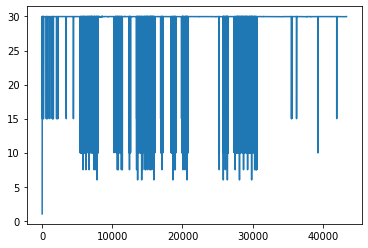

In [30]:
import matplotlib.pyplot as plt
plt.plot(freq)

# Segmentation

## read csv data created to store them

In [24]:
#reprend les donnes de csv , on peut en profiter pour les cut
index = {}
relative_time = {}
absolute_time = {}

for k in range(len(cameras)):
    camera = cameras[k]
    file = [x[2] for x in os.walk(join(data_folder, camera , 'CSV', 'complete'))]
    print(file[0][0])  
    
    directory = join(data_folder, camera , 'CSV', 'complete', file[0][0])
    print(directory)
    synchro.play(directory, camera)
    index[camera] = synchro.data[camera]['index']
    relative_time[camera] = synchro.data[camera]['relative_time']
    absolute_time[camera] = synchro.data[camera]['abs_time']
    #print(absolute_time[camera])
#print(relative_time)

outputGOPR_abs_time.csv
../data/test_19_04_22/ANAELLE_all4/GOPRO/CSV/complete/outputGOPR_abs_time.csv
outputMICR_abs_time.csv
../data/test_19_04_22/ANAELLE_all4/MICROSCOPE/CSV/complete/outputMICR_abs_time.csv
REALSENSE_abs_time.csv
../data/test_19_04_22/ANAELLE_all4/REALSENSE/CSV/complete/REALSENSE_abs_time.csv


In [25]:
# get sensor data from CSV

index_sensor = {}
relative_time_sensor = {}
absolute_time_sensor = {}
headers = {}
directory_sensor = {}


#file = [x[2] for x in os.walk(join(data_folder, 'SENSORS'))]
#print(file[0])  

for sensor in sensors:
    file = sensor + '.csv'
    print(file)
    directory_sensor[sensor] = join(data_folder, 'SENSORS', file)

    synchro.play(directory_sensor[sensor], sensor)
    index_sensor[sensor] = synchro.data[sensor]['index']
    relative_time_sensor[sensor] = synchro.data[sensor]['relative_time']
    absolute_time_sensor[sensor] = synchro.data[sensor]['absolute_time']
    
    f = open(directory_sensor[sensor])
    d_reader = csv.DictReader(f)
    #get fieldnames from DictReader object and store in list
    headers[sensor] = d_reader.fieldnames
    print(headers[sensor])

optitrack.csv
['index', 'absolute_time', 'relative_time', 'tweezers_x', 'tweezers_y', 'tweezers_z', 'tweezers_qx', 'tweezers_qy', 'tweezers_qz', 'tweezers_qw', 'scissors_x', 'scissors_y', 'scissors_z', 'scissors_qx', 'scissors_qy', 'scissors_qz', 'scissors_qw']
emg.csv
['index', 'absolute_time', 'relative_time', 'emg0', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7']
tps.csv
['index', 'absolute_time', 'relative_time', 'right_thumb_calibrated', 'right_thumb_raw', 'right_index_calibrated', 'right_index_raw', 'right_middle_calibrated', 'right_middle_raw']


## get closest no of frame and rel time to the ref no frame (on microscope) using absolute time, and export coresp videos (read microscope frame from csv)

In [26]:
camera_ref = "MICROSCOPE"

#get ref fram of microscope directly from csv file
file = [x[2] for x in os.walk(join(data_folder, 'SEGMENTATION_CSV'))]
print(file[0][0])  
    
directory = join(data_folder ,'SEGMENTATION_CSV', file[0][0])
print(directory)
DATA = pd.read_csv(directory)
start_ref_frame_vector = DATA['Start_frame']
stop_ref_frame_vector = DATA['Stop_frame']
index_segment_vector = DATA['nb']

    
for o in range(len(start_ref_frame_vector)):
    start_ref_frame = start_ref_frame_vector[o]
    print(start_ref_frame)
    stop_ref_frame = stop_ref_frame_vector[o]

    #camera = camera_ref
    start_ref_abs_time = absolute_time[camera_ref][start_ref_frame]
    stop_ref_abs_time = absolute_time[camera_ref][stop_ref_frame]
    #
    pos_start = {}
    pos_stop = {}
    rel_time_start = {}
    rel_time_stop = {}
    abs_time_start = {}
    abs_time_stop = {}
    duration_clip = {}
    clip = {}
    
    pos_start_sensor = {}
    pos_stop_sensor = {}
    abs_time_start_sensor = {}
    abs_time_stop_sensor = {}

    #for camera in cameras:
    print("start reference abs time:  ", start_ref_abs_time)  
    print("stop reference abs time:  ", stop_ref_abs_time) 
    print("----------------------")
    for camera in cameras:
        pos_start[camera] = []
        pos_stop[camera] = []
        rel_time_start[camera] = {}
        rel_time_stop[camera] = {}
        abs_time_start[camera] = {}
        abs_time_stop[camera] = {}
        duration_clip[camera] = {}
        if not camera in camera_ref:
            #print(absolute_time[camera])
            [pos_start[camera], abs_time_start[camera]]= synchro.take_closest(absolute_time[camera], start_ref_abs_time, frame[camera])
            print(camera, "start index:       ", pos_start[camera], "abs time:   ", abs_time_start[camera])
            [pos_stop[camera], abs_time_stop[camera]] = synchro.take_closest(absolute_time[camera], stop_ref_abs_time, frame[camera])
            print(camera, "stop index:        ", pos_stop[camera], "abs time:   ", abs_time_stop[camera])
            rel_time_start[camera] = relative_time[camera][pos_start[camera]]
            rel_time_stop[camera] = relative_time[camera][pos_stop[camera]]
            print(camera, "start index:       ", pos_start[camera], "rel time:   ", rel_time_start[camera])
            print(camera, "stop index:       ", pos_stop[camera], "rel time:   ", rel_time_stop[camera])
            print("----------------------")
        else:
            rel_time_start[camera] = relative_time[camera][start_ref_frame]
            rel_time_stop[camera]  = relative_time[camera][stop_ref_frame]
            #abs_time_start[camera] = absolute_time[camera][start_ref_frame]
            abs_time_start[camera] = start_ref_abs_time
            #abs_time_stop[camera]  = absolute_time[camera][stop_ref_frame]
            abs_time_stop[camera] = stop_ref_abs_time
            print(camera, "start index   ", start_ref_frame, "rel time:   ", rel_time_start[camera])
            print(camera, "stop index   ", stop_ref_frame, "rel time:   ", rel_time_stop[camera])
            print("----------------------")
            pos_start[camera] = start_ref_frame
            pos_stop[camera] = stop_ref_frame
            
        #export video from t1 to t2 in seconds

     
        #for camera in cameras:
        t1 = rel_time_start[camera]
        t2 = rel_time_stop[camera]
    
        #name with abs time ref
        #r1 = abs_time_start[camera]
        #r2 = abs_time_stop[camera]
        #ref = str(r1)[1:7] + "_to_" + str(r2)[1:7] + ".mp4"
    
        #name with no of frame
        r1 = pos_start[camera]
        r2 = pos_stop[camera]
        ref = str(r1) + "_to_" + str(r2) + ".mp4"

        #name with rel time
        #ref = str(t1)[1:7] + "_to_" + str(t2)[1:7] + ".mp4"
    
        #name with rsegment nb
        r1 = index_segment_vector[o]
        ref = "segment_nb_" + str(r1) + ".mp4"
        
        file = [x[2] for x in os.walk(join(data_folder, camera , 'complete'))]
        print(file[0][0])  
        target_name = join(path_to_data_folder, recording_session, subject, camera , 'SEGMENTATION', ref)
        file_name = join(data_folder, camera, 'complete', file[0][0])
        print(target_name)
        ffmpeg_extract_subclip(file_name, t1, t2, targetname=target_name)
        
        clip[camera] = VideoFileClip(target_name)
        duration_clip[camera] = t2 - t1
        
    smallest_duration = min(duration_clip.values())
   
    
    output_blank = join(path_to_data_folder, recording_session, subject, 'blank_video.mp4')

    size = (200, 100)
    duration = (smallest_duration)
    print(duration)
    synchro.color_clip(size, duration, output_blank)
    clip4 = VideoFileClip(output_blank)
        
    # clips list
    clips = [[clip['MICROSCOPE'], clip['REALSENSE'].resize(1.4)],
             [clip4, clip['GOPRO']]]
 
    # stacking clips
    final = clips_array(clips, rows_widths=[1000, 1000], cols_widths=[2000, 2000])
 
    # showing final clip
    #final.ipython_display(width = 480)
    ref2 = "segment_nb_" + str(r1) + "_all_views.mp4"
    output_name = join(path_to_data_folder, recording_session, subject, 'ALL_VIEWS', ref2)
    final.set_duration(smallest_duration).write_videofile(output_name, fps=30, remove_temp=True, audio = False)
      
    
    for sensor in sensors:
        pos_start_sensor[sensor] = []
        pos_stop_sensor[sensor] = []
        abs_time_start_sensor[sensor] = {}
        abs_time_stop_sensor[sensor] = {}
        
        [pos_start_sensor[sensor], abs_time_start_sensor[sensor]]= synchro.take_closest(absolute_time_sensor[sensor]*1000, start_ref_abs_time, 0)
        print(sensor, "start index:       ", pos_start_sensor[sensor], "     abs time:   ", abs_time_start_sensor[sensor])
        [pos_stop_sensor[sensor], abs_time_stop_sensor[sensor]] = synchro.take_closest(absolute_time_sensor[sensor]*1000, stop_ref_abs_time, 0)
        print(sensor, "stop index:        ", pos_stop_sensor[sensor], "      abs time:   ", abs_time_stop_sensor[sensor])
        
        r1 = index_segment_vector[o]
        ref = "segment_nb_" + str(r1) + "_" + sensor + ".csv"
        csv_name = join(data_folder,'SENSORS', 'SEGMENTATION', ref)
          
        f = open(csv_name, 'w', newline='') # open the file in the write mode                        #open last one
    
        # create the csv writer
        writer = csv.writer(f)
       
        # write a row to the csv file
        writer.writerow(headers[sensor])
        table = pd.read_csv(directory_sensor[sensor],skiprows=pos_start_sensor[sensor]-1,nrows=(pos_stop_sensor[sensor] - pos_start_sensor[sensor]+1))
        table2 = table.to_numpy()
    
        for m in range(pos_stop_sensor[sensor] - pos_start_sensor[sensor]+1):
            row = table2[m]
            writer.writerow(row)
            # print(row)
    
        f.close()        
   
    #export videos parts according to microscope frames

segmentation_micro_frames.csv
../data/test_19_04_22/ANAELLE_all4/SEGMENTATION_CSV/segmentation_micro_frames.csv
4000
start reference abs time:   1650380390104.8752
stop reference abs time:   1650380406771.6233
----------------------
GOPRO start index:        1078 abs time:    1650380390104.871
GOPRO stop index:         1578 abs time:    1650380406771.4973
GOPRO start index:        1078 rel time:    35.933333333333856
GOPRO stop index:        1578 rel time:    52.599999999999575
----------------------
outputGOPRO.mp4
/home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/GOPRO/SEGMENTATION/segment_nb_1.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
MICROSCOPE start index    4000 rel time:    66.66666666666417
MICROSCOPE stop index    5000 rel time:    83.33333333332989
----------------------
outputMICROSCOPE.mp4
/home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/MICROSCOPE/SEGMENTATION/segment_nb_1.mp4
Moviepy - Running:
>>> "+ " "

Moviepy - Done !
Moviepy - video ready /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/blank_video.mp4


Moviepy - Building video /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_1_all_views.mp4.
Moviepy - Writing video /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_1_all_views.mp4



Moviepy - Done !
Moviepy - video ready /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_1_all_views.mp4
optitrack start index:        6846      abs time:    1650380390099.0586
optitrack stop index:         8278       abs time:    1650380406771.574
emg start index:        83836      abs time:    1650380390104.5525
emg stop index:         99607       abs time:    1650380406772.451
tps start index:        2342      abs time:    1650380390048.5645
tps stop index:         2775       abs time:    1650380406813.0613
8000
start reference abs time:   1650380456771.8674
stop reference abs time:   1650380473438.6155
----------------------
GOPRO start index:        3078 abs time:    1650380456771.3752
GOPRO stop index:         3578 abs time:    1650380473438.0012
GOPRO start index:        3078 rel time:    102.59999999999674
GOPRO stop index:        3578 rel time:    119.26666666666246
----------------------
outputGOPRO.mp4
/home/anaelle/git/surgeon_recordin

Moviepy - Done !
Moviepy - video ready /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/blank_video.mp4


Moviepy - Building video /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_2_all_views.mp4.
Moviepy - Writing video /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_2_all_views.mp4



Moviepy - Done !
Moviepy - video ready /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_2_all_views.mp4
optitrack start index:        12336      abs time:    1650380456779.0679
optitrack stop index:         13717       abs time:    1650380473443.5793
emg start index:        146629      abs time:    1650380456772.2615
emg stop index:         161765       abs time:    1650380473438.4084
tps start index:        4063      abs time:    1650380456715.0642
tps stop index:         4491       abs time:    1650380473405.5588
15000
start reference abs time:   1650380573439.1038
stop reference abs time:   1650380590105.8518
----------------------
GOPRO start index:        6578 abs time:    1650380573437.757
GOPRO stop index:         7078 abs time:    1650380590104.383
GOPRO start index:        6578 rel time:    219.2666666666568
GOPRO stop index:        7078 rel time:    235.9333333333225
----------------------
outputGOPRO.mp4
/home/anaelle/git/surgeon_recor

Moviepy - Done !
Moviepy - video ready /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/blank_video.mp4


Moviepy - Building video /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_3_all_views.mp4.
Moviepy - Writing video /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_3_all_views.mp4



Moviepy - Done !
Moviepy - video ready /home/anaelle/git/surgeon_recording/data/test_19_04_22/ANAELLE_all4/ALL_VIEWS/segment_nb_3_all_views.mp4
optitrack start index:        22352      abs time:    1650380573446.5586
optitrack stop index:         23765       abs time:    1650380590109.0618
emg start index:        255451      abs time:    1650380573438.76
emg stop index:         270718       abs time:    1650380590107.1912
tps start index:        7040      abs time:    1650380573429.0789
tps stop index:         7467       abs time:    1650380590106.0645


## export segments of sensors